## Model Loading

In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Define the custom loss function
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            loss += -1 * tf.reduce_mean(
                pos_weights[i] * y_true[:, i] * tf.math.log(y_pred[:, i] + epsilon)
            ) + -1 * tf.reduce_mean(
                neg_weights[i] * (1 - y_true[:, i]) * tf.math.log(1 - y_pred[:, i] + epsilon)
            )
        return loss
    return weighted_loss

# Define your labels
labels =  [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 
    'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
    'No Finding', 'Pleural Other', 'Pleural Effusion',
    'Pneumonia', 'Pneumothorax', 'Support Devices'
]
# Create dummy weights for model loading
pos_weights = np.ones(len(labels))
neg_weights = np.ones(len(labels))

# Recreate the model architecture
base_model = DenseNet121(weights=None, include_top=False, input_shape=(320, 320, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(labels), activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
model.compile(
    optimizer=optimizer, 
    loss=get_weighted_loss(pos_weights, neg_weights),
    metrics=['accuracy']
)

# Load the weights
model.load_weights('my_model_weights.h5')
print("Model weights loaded successfully")

# Now you can use the model for predictions
def predict_with_model(model, test_generator):
    # Make predictions
    predicted_vals = model.predict(test_generator, steps=len(test_generator))
    return predicted_vals

Model weights loaded successfully


## Test Generator

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util
from sklearn.model_selection import train_test_split
df=pd.read_csv("../mimic_train.csv")

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
test_df = pd.read_csv("inference.csv")



In [24]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=16, seed=1, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    test_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    valid_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator, valid_generator

In [25]:
IMAGE_DIR = "../mimic_cxr/images"
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train and valid generators...
Found 84578 validated image filenames.
Found 21145 validated image filenames.
Found 2267 validated image filenames.


In [28]:
test_generator.n

2267

## Prediction

In [29]:
predicted_vals = model.predict(test_generator, steps=len(test_generator))

In [30]:
def generate_pathology_report(predicted_vals, labels):

    all_predictions = []
    
    # Process each image prediction
    for i in range(len(predicted_vals)):
        # Get predictions for this image
        prediction = predicted_vals[i]
        
        # Create dictionary mapping pathology names to probabilities
        pathology_probs = {label: float(prob) for label, prob in zip(labels, prediction)}
        
        # Sort by probability (highest first)
        sorted_probs = dict(sorted(pathology_probs.items(), key=lambda x: x[1], reverse=True))
        
        all_predictions.append(pathology_probs)
    
    return all_predictions

# Get test image filenames
test_filenames = test_generator.filenames if hasattr(test_generator, 'filenames') else None

# Generate pathology reports
pathology_reports = generate_pathology_report(predicted_vals, labels)

# Display the predictions for the first 5 images
for i, report in enumerate(pathology_reports[:5]):
    print(f"\nImage {i+1}:")
    print("-" * 40)
    
    if test_filenames:
        print(f"Filename: {test_filenames[i]}")
    
    print("Pathology Predictions:")
    for pathology, probability in report.items():
        # Only show probabilities above a threshold (e.g., 1%)
        if probability > 0.01:
            print(f"{pathology}: {probability:.4f}")


Image 1:
----------------------------------------
Filename: p11/p11941242/s50000014/dffc8ab2-ff37704f-2fb29e6d-51e08075-88bca914.jpg
Pathology Predictions:
Atelectasis: 0.8422
Cardiomegaly: 0.6258
Consolidation: 0.6399
Edema: 0.6463
Enlarged Cardiomediastinum: 0.7143
Fracture: 0.4241
Lung Lesion: 0.1459
Lung Opacity: 0.6317
No Finding: 0.1341
Pleural Other: 0.2811
Pleural Effusion: 0.8437
Pneumonia: 0.3650
Pneumothorax: 0.6340
Support Devices: 0.7183

Image 2:
----------------------------------------
Filename: p14/p14444780/s50000186/93bcf53f-7c91b330-3738f326-4d31769d-6cff6fe5.jpg
Pathology Predictions:
Atelectasis: 0.5781
Cardiomegaly: 0.2572
Consolidation: 0.3125
Edema: 0.1160
Enlarged Cardiomediastinum: 0.4816
Fracture: 0.4671
Lung Lesion: 0.2909
Lung Opacity: 0.5955
No Finding: 0.4509
Pleural Other: 0.4354
Pleural Effusion: 0.2214
Pneumonia: 0.5866
Pneumothorax: 0.1213
Support Devices: 0.1812

Image 3:
----------------------------------------
Filename: p16/p16548129/s50000198/b66

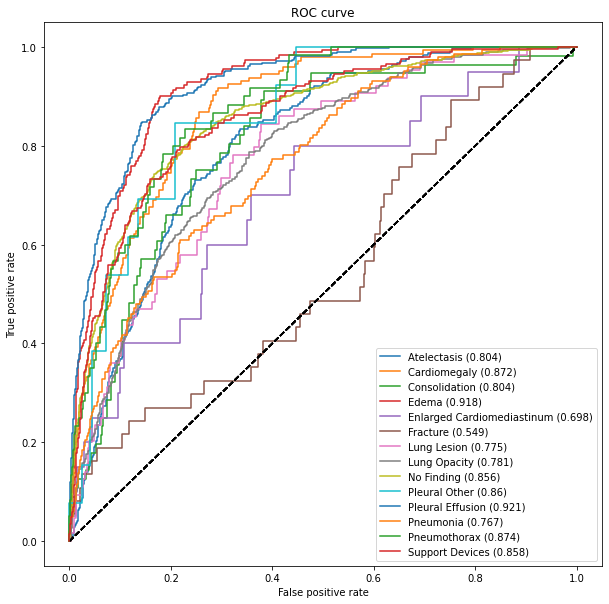

In [31]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [32]:
labels_df = pd.read_csv("../mimic-cxr-2.0.0-chexpert.csv")

labels_df['study_id'] = labels_df['study_id'].astype(str)

import pandas as pd

# Define the specific order for pathologies
ordered_pathologies = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 
    'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
    'No Finding', 'Pleural Other', 'Pleural Effusion',
    'Pneumonia', 'Pneumothorax', 'Support Devices'
]

# Create empty DataFrame with desired columns
results_df = pd.DataFrame(columns=['subject_id', 'study_id', 'classification_result'])

# Process each prediction
for i, report in enumerate(pathology_reports):
    # Skip if we don't have filenames or we're past the available filenames
    if not test_filenames or i >= len(test_filenames):
        continue
        
    # Extract filename
    filename = test_filenames[i]
    
    # Extract study_id from filename
    import re
    study_id_match = re.search(r's(\d+)', filename)
    if not study_id_match:
        continue
        
    study_id = study_id_match.group(1)
    
    # Find corresponding subject_id in labels_df
    match = labels_df[labels_df['study_id'] == study_id]
    if len(match) == 0:
        continue
        
    subject_id = str(match.iloc[0]['subject_id'])
    
    # Create an ordered classification result
    ordered_result = []
    
    # Add pathologies in the specified order
    for pathology in ordered_pathologies:
        if pathology in report:
            prob = report[pathology]
            prob_str = f"{prob:.4f}"
            ordered_result.append((pathology, prob_str))
    
    # Add to results DataFrame
    new_row = {
        'subject_id': subject_id,
        'study_id': study_id,
        'classification_result': str(ordered_result)
    }
    results_df = results_df.append(new_row, ignore_index=True)

results_df.to_csv('inference_2000.csv', index=False)

# Print first few rows
print(results_df.head())

  subject_id  study_id                              classification_result
0   11941242  50000014  [('Atelectasis', '0.8422'), ('Cardiomegaly', '...
1   14444780  50000186  [('Atelectasis', '0.5781'), ('Cardiomegaly', '...
2   16548129  50000198  [('Atelectasis', '0.1009'), ('Cardiomegaly', '...
3   11550925  50000230  [('Atelectasis', '0.5507'), ('Cardiomegaly', '...
4   13797827  50000319  [('Atelectasis', '0.5307'), ('Cardiomegaly', '...
